In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pickle
import wasp
from tqdm.autonotebook import tqdm
from itertools import chain
from IPython.display import display, Markdown

C:\Python37\lib\site-packages\ipykernel_launcher.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
with open(wasp.get_data_path('sem_graph', 'concept_net.pkl'), "rb") as fin:
    cn = pickle.load(fin)
cn_tokens = list(cn.keys())

In [4]:
cn_valid_tokens = list(filter(lambda x: cn[x][0].get("error", {}).get("status", -1) != 404, cn_tokens))

In [5]:
sum([len(cn[x]) for x in cn_valid_tokens])

5936

In [6]:
display(Markdown(f"### There are {len(cn_valid_tokens)} nodes found in ConceptNet"))

### There are 4055 nodes found in ConceptNet

In [7]:
cn_valid_tokens[0]

'鞋子'

In [8]:
def retrieve_edge(edge_x):    
    rel_type = edge_x["rel"]["@type"]
    end_lang = edge_x["end"].get("language")    
    start_lang = edge_x["start"].get("language")
    
    if rel_type != "Relation" or end_lang != "zh" \
        or start_lang != "zh":
        return None
    else:
        rel_label = edge_x["rel"]["label"]
        start = edge_x["start"]["label"]
        end = edge_x["end"]["label"]
        weight = edge_x.get("weight", 0)
        return (start, rel_label, end, weight)

In [9]:
rel_data = {}
for tok in cn_valid_tokens:
    edge_iter = chain.from_iterable(x["edges"] for x in cn[tok])
    rel_iter = map(retrieve_edge, edge_iter)
    rel_iter = filter(lambda x: x and x[3] > 1, rel_iter)
    rel_data[tok] = list(set(rel_iter))

In [10]:
edge_count = sum([len(x) for x in rel_data.values()])
display(Markdown(f"### There are {edge_count} relations retrieved from ConceptNet"))

### There are 52131 relations retrieved from ConceptNet

In [11]:
import networkx  as nx

In [12]:
G = nx.Graph()

In [13]:
for start_x, edges in rel_data.items():
    G.add_node(start_x)
    for edge_x in edges:   
        start_x, rel_label, end_x, _ = edge_x
        G.add_node(start_x)
        G.add_node(end_x)
        G.add_edge(start_x, end_x, rel=rel_label)            

In [14]:
n_largest_compo = max(len(x) for x in nx.connected_components(G))

In [15]:
display(Markdown(f"The Graph from conceptnet has \n"
        f"* {len(G.nodes)} nodes, {len(G.edges)} edges \n"
        f"* {nx.number_connected_components(G)} islands \n"
        f"* {len(list(nx.isolates(G)))} of which has single nodes, \n"
        f"* The largest island has {n_largest_compo} nodes"))

The Graph from conceptnet has 
* 15074 nodes, 33424 edges 
* 2515 islands 
* 2443 of which has single nodes, 
* The largest island has 12469 nodes

In [16]:
G.adj["能力"]

AtlasView({'錢': {'rel': 'HasSubevent'}, '認真': {'rel': 'MotivatedByGoal'}, '學習': {'rel': 'MotivatedByGoal'}, '讀書': {'rel': 'Causes'}, '努力': {'rel': 'MotivatedByGoal'}, '補習': {'rel': 'MotivatedByGoal'}, '愛': {'rel': 'IsA'}, '才華': {'rel': 'SymbolOf'}})

In [17]:
graph_1_path = wasp.get_data_path("sem_graph", "graph_stage_1.pkl")
with open(graph_1_path, "wb") as fout:
    pickle.dump(G, fout)

# Query FastText

In [18]:
import pickle
import wasp

In [38]:
with open(wasp.get_resource_path("", "fasttext_vocab_freq.pkl"), "rb") as fin:
    ft_vocab = pickle.load(fin)

In [39]:
with open(wasp.get_resource_path("", "gensim_kv_fasttext_tc.pkl"), "rb") as fin:
    fasttext = pickle.load(fin)

In [40]:
vocab_freq = {}
for tok in fasttext.vocab.keys():
    vocab_freq[tok] = ft_vocab.get(tok, 1)
del ft_vocab

In [44]:
freq_sorted = sorted(fasttext.vocab.keys(), key=lambda x: fasttext.vocab.get(x, 1), reverse=True)
stop_words = set(freq_sorted[:1000])

In [45]:
fasttext.similarity("醫生", "梨子")

0.8844398365954318

In [46]:
from itertools import combinations
vocab = fasttext.vocab
cn_vocab = [x for x in cn.keys() if x in vocab]
print(f"cn_vocab: {len(cn_vocab)}")
assoc = {}
n_comb = len(cn_vocab) * (len(cn_vocab)-1)/2
for tok_x, tok_y in tqdm(combinations(cn_vocab, 2), total=n_comb):    
    if not(tok_x in vocab and tok_y in vocab):
        continue
    if tok_x in stop_words or tok_y in stop_words:
        continue
    if tok_x == tok_y:
        continue
    assoc[(tok_x, tok_y)] = fasttext.similarity(tok_x, tok_y)

cn_vocab: 4408


In [47]:
with open(wasp.get_data_path("sem_graph", "cn_fasttext_assoc.pkl"), "wb") as fin:
    pickle.dump(assoc, fin)

In [48]:
assoc_values = list(assoc.values())

In [49]:
import numpy as np
np.quantile(assoc_values, [.80, .90, .95])
assoc_crit = np.quantile(assoc_values, [.90])[0]

In [50]:
assoc_crit

0.9262614339353522

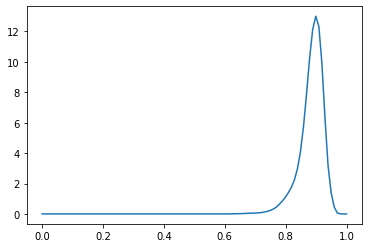

In [51]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
density = gaussian_kde(assoc_values)
xs = np.linspace(0,1,100)
plt.plot(xs, density(xs))

## add fasttext assoc in graph

In [52]:
graph_1_path = wasp.get_data_path("sem_graph", "graph_stage_1.pkl")
with open(graph_1_path, "rb") as fin:
    G = pickle.load(fin)

with open(wasp.get_data_path("sem_graph", "cn_fasttext_assoc.pkl"), "rb") as fin:
    assoc = pickle.load(fin)

In [53]:
for tok_tup, sim in tqdm(assoc.items()):
    if sim > assoc_crit:
        G.add_edge(*tok_tup, rel="fasttext")

In [54]:
display(Markdown(f"The Graph from conceptnet has \n"
        f"* {len(G.nodes)} nodes, {len(G.edges)} edges \n"
        f"* {nx.number_connected_components(G)} islands \n"
        f"* {len(list(nx.isolates(G)))} of which has single nodes, \n"
        f"* The largest island has {n_largest_compo} nodes"))

The Graph from conceptnet has 
* 15600 nodes, 807426 edges 
* 633 islands 
* 608 of which has single nodes, 
* The largest island has 12469 nodes

In [55]:
graph_2_path = wasp.get_data_path("sem_graph", "graph_stage_2.pkl")
with open(graph_2_path, "wb") as fout:
    pickle.dump(G, fout)